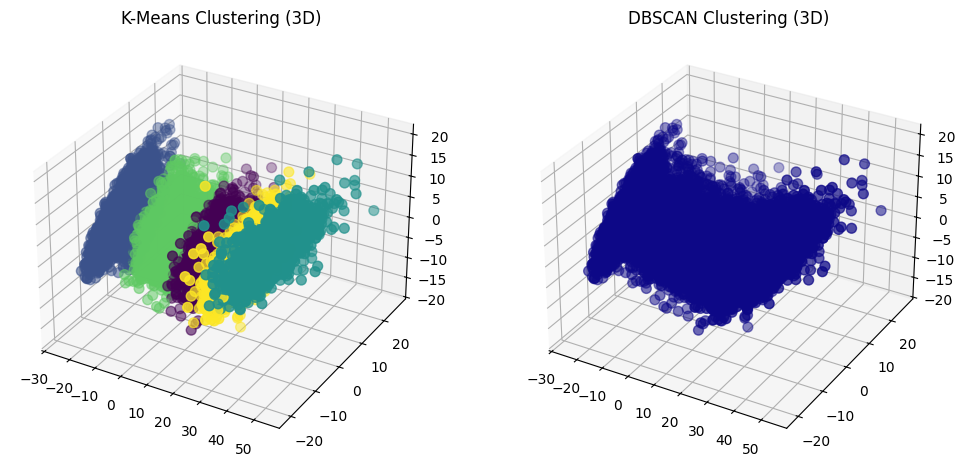

In [1]:
import pandas as pd
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from transformers import BertModel, BertTokenizer
import torch
import matplotlib.pyplot as plt

# 데이터 로드
df = pd.read_csv('train 수정.csv')

# 필요한 컬럼 추출
dialogues = df['dialogue'].tolist()

# BERT 모델 및 토크나이저 로드
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# 스페셜 토큰 정의
special_tokens = {
    'additional_special_tokens': ['#Person1#', 
                                  '#Person2#', 
                                  '#Person3#',
                                  '#Person4#',
                                  '#Person5#',
                                  '#Person6#',
                                  '#Person7#'
                                  '#SSN#',
                                  '#PhoneNumber#',
                                  '#Address#',
                                  '#Email#',
                                  '#CarNumber#',
                                  '#CardNumber#',
                                  '#DateOfBirth#',
                                  '#PassportNumber#']
}

# 스페셜 토큰을 토크나이저에 추가
tokenizer.add_special_tokens(special_tokens)
# 모델에 스페셜 토큰 반영
model.resize_token_embeddings(len(tokenizer))

# 임베딩 생성 함수
def get_bert_embeddings(text_list):
    embeddings = []
    with torch.no_grad():
        for text in text_list:
            # 텍스트 토크나이즈 및 패딩, 잘림 처리
            inputs = tokenizer(text, return_tensors='pt', truncation=True, padding='max_length', max_length=512)
            outputs = model(**inputs)
            embeddings.append(outputs.last_hidden_state.mean(dim=1).squeeze().numpy())
    return embeddings

# Dialogue 임베딩 생성
dialogue_embeddings = get_bert_embeddings(dialogues)

# 데이터 스케일링 (StandardScaler 사용)
scaler = StandardScaler()
scaled_embeddings = scaler.fit_transform(dialogue_embeddings)

# 3차원 PCA로 차원 축소 (시각화를 위해)
pca = PCA(n_components=3)
pca_embeddings = pca.fit_transform(scaled_embeddings)

# K-Means 군집화
n_clusters = 5  # 클러스터 수 설정
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_clusters = kmeans.fit_predict(scaled_embeddings)

# DBSCAN 군집화
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_clusters = dbscan.fit_predict(scaled_embeddings)

# 3D 시각화
fig = plt.figure(figsize=(12, 6))

# K-Means 결과 3D 시각화
ax = fig.add_subplot(121, projection='3d')
ax.scatter(pca_embeddings[:, 0], pca_embeddings[:, 1], pca_embeddings[:, 2], c=kmeans_clusters, cmap='viridis', s=50)
ax.set_title('K-Means Clustering (3D)')

# DBSCAN 결과 3D 시각화
ax = fig.add_subplot(122, projection='3d')
ax.scatter(pca_embeddings[:, 0], pca_embeddings[:, 1], pca_embeddings[:, 2], c=dbscan_clusters, cmap='plasma', s=50)
ax.set_title('DBSCAN Clustering (3D)')


plt.show()

# 클러스터링 결과를 데이터프레임에 추가
df['kmeans_cluster'] = kmeans_clusters
df['dbscan_cluster'] = dbscan_clusters

# 결과 저장
df.to_csv('clustered_dialogues.csv', index=False)